# Pipeline 1: Binary Classification (Healthy vs Disease)

This pipeline creates a balanced dataset for binary classification:
- Class 0: Healthy
- Class 1: Disease (any disease)

Target: Perfect 50/50 balance for optimal training.

## Step 1: Configuration Setup

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import re
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
# Load environment variables
load_dotenv()

# Find project root
PROJECT_ROOT = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent

def make_absolute(path_str):
    """Convert relative path from .env to absolute path."""
    path = Path(path_str)
    return path.resolve() if path.is_absolute() else (PROJECT_ROOT / path).resolve()

# Dataset paths
TRAIN_LABELS_CSV = make_absolute(os.getenv('TRAIN_LABELS_CSV'))
TEST_LABELS_CSV = make_absolute(os.getenv('TEST_LABELS_CSV'))
TRAIN_IMAGES_DIR = make_absolute(os.getenv('TRAIN_IMAGES_DIR'))
TEST_IMAGES_DIR = make_absolute(os.getenv('TEST_IMAGES_DIR'))

# Output paths for BINARY classification
OUTPUT_BINARY_BASE_DIR = PROJECT_ROOT / 'dataset' / 'binary'
OUTPUT_BINARY_IMAGES_TRAIN = OUTPUT_BINARY_BASE_DIR / 'images' / 'train'
OUTPUT_BINARY_IMAGES_VAL = OUTPUT_BINARY_BASE_DIR / 'images' / 'val'
OUTPUT_BINARY_LABELS_TRAIN = OUTPUT_BINARY_BASE_DIR / 'labels' / 'train'
OUTPUT_BINARY_LABELS_VAL = OUTPUT_BINARY_BASE_DIR / 'labels' / 'val'

# Plant species
PLANT_SPECIES = [s.strip() for s in os.getenv('PLANT_SPECIES').split(',')]

print("✓ Configuration loaded!")
print(f"\nProject root: {PROJECT_ROOT}")
print(f"Output: {OUTPUT_BINARY_BASE_DIR}")

✓ Configuration loaded!

Project root: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection
Output: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/binary


## Step 2: Load and Clean Data

In [3]:
# Load data
df_train = pd.read_csv(TRAIN_LABELS_CSV)
df_test = pd.read_csv(TEST_LABELS_CSV)

print(f"Loaded: {len(df_train)} train, {len(df_test)} test samples")

# Clean class names
for df in [df_train, df_test]:
    df['class'] = (
        df['class']
        .str.replace(r'(?i)leaf', '', regex=True)
        .str.replace(r'\s+', ' ', regex=True)
        .str.replace(r'_', ' ', regex=True)
        .str.strip()
    )

print("✓ Class names cleaned")

Loaded: 8469 train, 452 test samples
✓ Class names cleaned


## Step 3: Extract Features

In [4]:
def extract_species(text):
    for plant in PLANT_SPECIES:
        if re.search(rf"\b{plant}\b", text, flags=re.IGNORECASE):
            return plant
    return None

def extract_disease(text):
    for plant in PLANT_SPECIES:
        text = re.sub(rf"\b{plant}\b", "", text, flags=re.IGNORECASE).strip()
    return text if text else "healthy"

# Extract features
df_train['species'] = df_train['class'].apply(extract_species)
df_train['disease'] = df_train['class'].apply(extract_disease)
df_test['species'] = df_test['class'].apply(extract_species)
df_test['disease'] = df_test['class'].apply(extract_disease)

print("✓ Features extracted")
print(df_train[['class', 'species', 'disease']].head())

✓ Features extracted
    class species  disease
0  Cherry  Cherry  healthy
1  Cherry  Cherry  healthy
2  Cherry  Cherry  healthy
3  Cherry  Cherry  healthy
4   Peach   Peach  healthy


## Step 4: Fix Zero Dimensions

In [5]:
def fix_zero_dimensions(df, image_folder):
    image_folder = Path(image_folder)
    for idx, row in df.iterrows():
        if row['width'] == 0 or row['height'] == 0:
            image_path = image_folder / row['filename']
            if image_path.exists():
                with Image.open(image_path) as img:
                    w, h = img.size
                    df.at[idx, 'width'] = w
                    df.at[idx, 'height'] = h
    return df

df_train = fix_zero_dimensions(df_train, TRAIN_IMAGES_DIR)
df_test = fix_zero_dimensions(df_test, TEST_IMAGES_DIR)
print("✓ Dimensions fixed")

✓ Dimensions fixed


## Step 5: Verify Files Exist

In [6]:
def verify_files_exist(df, image_folder):
    image_folder = Path(image_folder)
    existing_mask = []
    for _, row in df.iterrows():
        existing_mask.append((image_folder / row['filename']).exists())
    return df[existing_mask].copy()

df_train = verify_files_exist(df_train, TRAIN_IMAGES_DIR)
df_test = verify_files_exist(df_test, TEST_IMAGES_DIR)
print(f"✓ Verified: {len(df_train)} train, {len(df_test)} test samples")

✓ Verified: 8461 train, 452 test samples


## Step 6: Create Binary Labels (Healthy vs Disease)

In [7]:
# Create binary label: 0 = healthy, 1 = disease
df_train['binary_class'] = (df_train['disease'] != 'healthy').astype(int)
df_test['binary_class'] = (df_test['disease'] != 'healthy').astype(int)

Binary class distribution:
  Class 0 (Healthy): 4039 samples
  Class 1 (Disease): 4422 samples

  Ratio: 0.91:1 (Healthy:Disease)


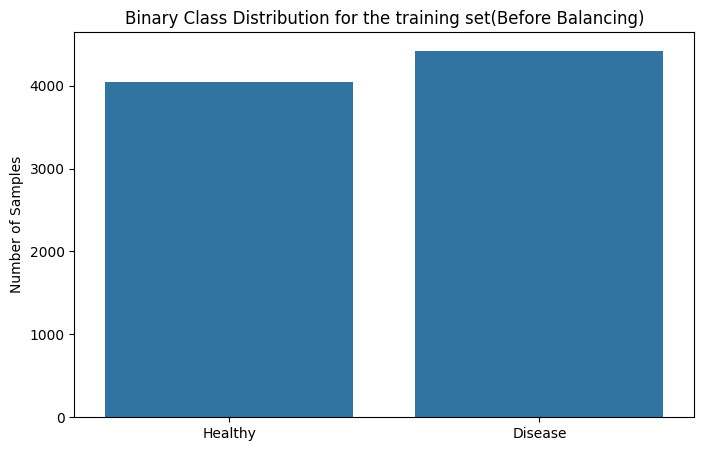

In [8]:
# Count samples
healthy_count = (df_train['binary_class'] == 0).sum()
disease_count = (df_train['binary_class'] == 1).sum()

print("Binary class distribution:")
print(f"  Class 0 (Healthy): {healthy_count} samples")
print(f"  Class 1 (Disease): {disease_count} samples")
print(f"\n  Ratio: {healthy_count/disease_count:.2f}:1 (Healthy:Disease)")

# Visualize
plt.figure(figsize=(8, 5))
sns.barplot(x=['Healthy', 'Disease'], y=[healthy_count, disease_count])
plt.title('Binary Class Distribution for the training set(Before Balancing)')
plt.ylabel('Number of Samples')
plt.show()

Binary class distribution:
  Class 0 (Healthy): 181 samples
  Class 1 (Disease): 271 samples

  Ratio: 0.67:1 (Healthy:Disease)


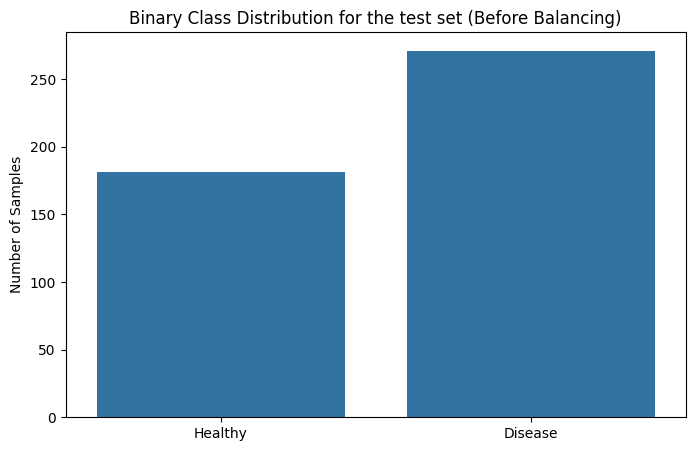

In [9]:
# Count samples
healthy_count = (df_test['binary_class'] == 0).sum()
disease_count = (df_test['binary_class'] == 1).sum()

print("Binary class distribution:")
print(f"  Class 0 (Healthy): {healthy_count} samples")
print(f"  Class 1 (Disease): {disease_count} samples")
print(f"\n  Ratio: {healthy_count/disease_count:.2f}:1 (Healthy:Disease)")

# Visualize
plt.figure(figsize=(8, 5))
sns.barplot(x=['Healthy', 'Disease'], y=[healthy_count, disease_count])
plt.title('Binary Class Distribution for the test set (Before Balancing)')
plt.ylabel('Number of Samples')
plt.show()

## Step 7: Seperate healthy and disease

In [10]:
# Separate healthy and disease
df_healthy_train = df_train[df_train['binary_class'] == 0].copy()
df_disease_train = df_train[df_train['binary_class'] == 1].copy()

# Combine
df_binary_train = pd.concat([df_healthy_train, df_disease_train], ignore_index=True)

In [11]:
# Separate healthy and disease
df_healthy_test = df_test[df_test['binary_class'] == 0].copy()
df_disease_test = df_test[df_test['binary_class'] == 1].copy()

# Combine
df_binary_test = pd.concat([df_healthy_test, df_disease_test], ignore_index=True)

## Step 8: Create Output Directories

In [12]:
OUTPUT_BINARY_IMAGES_TRAIN.mkdir(parents=True, exist_ok=True)
OUTPUT_BINARY_IMAGES_VAL.mkdir(parents=True, exist_ok=True)
OUTPUT_BINARY_LABELS_TRAIN.mkdir(parents=True, exist_ok=True)
OUTPUT_BINARY_LABELS_VAL.mkdir(parents=True, exist_ok=True)

print("✓ Output directories created")
print(f"  {OUTPUT_BINARY_BASE_DIR}")

✓ Output directories created
  /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/binary


## Step 9: Convert to YOLO Format and Export

In [13]:
def convert_bbox_to_yolo(row):
    x_center = (row['xmin'] + row['xmax']) / 2 / row['width']
    y_center = (row['ymin'] + row['ymax']) / 2 / row['height']
    bbox_width = (row['xmax'] - row['xmin']) / row['width']
    bbox_height = (row['ymax'] - row['ymin']) / row['height']
    return x_center, y_center, bbox_width, bbox_height

In [14]:
def export_to_yolo(df, images_dir, output_images_dir, output_labels_dir):
    exported = 0
    for filename, group in df.groupby("filename"):
        try:
            src = Path(images_dir) / filename
            dst = Path(output_images_dir) / filename
            shutil.copy2(src, dst)

            label_file = Path(output_labels_dir) / (Path(filename).stem + ".txt")
            with open(label_file, "w") as f:
                for _, row in group.iterrows():
                    cls_idx = row['binary_class']
                    x_c, y_c, w, h = convert_bbox_to_yolo(row)
                    f.write(f"{cls_idx} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")
            exported += 1
        except Exception as e:
            print(f"Error: {filename} - {e}")
    return exported

In [15]:
print("Exporting TRAINING data to YOLO format...")
exported_train = export_to_yolo(df_binary_train, TRAIN_IMAGES_DIR, OUTPUT_BINARY_IMAGES_TRAIN, OUTPUT_BINARY_LABELS_TRAIN)
print(f"✓ Exported {exported_train} images to train set")

Exporting TRAINING data to YOLO format...
✓ Exported 2343 images to train set


In [16]:
# Process test data for validation set
# Create binary labels for test data
df_test['binary_class'] = (df_test['disease'] != 'healthy').astype(int)

print("\nExporting TEST data to VALIDATION set...")
exported_val = export_to_yolo(df_test, TEST_IMAGES_DIR, OUTPUT_BINARY_IMAGES_VAL, OUTPUT_BINARY_LABELS_VAL)
print(f"✓ Exported {exported_val} images to val set")

# Show distribution
val_healthy = (df_test['binary_class'] == 0).sum()
val_disease = (df_test['binary_class'] == 1).sum()
print(f"\nValidation set distribution:")
print(f"  Healthy: {val_healthy}")
print(f"  Disease: {val_disease}")


Exporting TEST data to VALIDATION set...
✓ Exported 236 images to val set

Validation set distribution:
  Healthy: 181
  Disease: 271


## Step 10: Generate YAML Configuration

In [17]:
import yaml

yaml_content = {
    'path': str(OUTPUT_BINARY_BASE_DIR.resolve()),
    'train': 'images/train',
    'val': 'images/val',
    'nc': 2,
    'names': {0: 'healthy', 1: 'disease'}
}

yaml_path = OUTPUT_BINARY_BASE_DIR / 'dataset.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)

print("✓ YAML configuration created")
print(f"\nLocation: {yaml_path}")
print(f"\nClasses:")
print(f"  0: healthy")
print(f"  1: disease")

✓ YAML configuration created

Location: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/binary/dataset.yaml

Classes:
  0: healthy
  1: disease


## Step 11: Summary

In [18]:
print("=" * 60)
print("BINARY CLASSIF_trainICATION DATASET READY")
print("=" * 60)
print(f"\n📊 Dataset: {len(df_binary_train)} samples")
print(f"  - Class 0 (Healthy): {(df_binary_train['binary_class'] == 0).sum()}")
print(f"  - Class 1 (Disease): {(df_binary_train['binary_class'] == 1).sum()}")
print(f"\n📁 Location: {OUTPUT_BINARY_BASE_DIR}")
print(f"📝 Config: {yaml_path}")
print(f"\n✅ Ready for YOLO training!")
print("=" * 60)

BINARY CLASSIF_trainICATION DATASET READY

📊 Dataset: 8461 samples
  - Class 0 (Healthy): 4039
  - Class 1 (Disease): 4422

📁 Location: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/binary
📝 Config: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/binary/dataset.yaml

✅ Ready for YOLO training!
